In [7]:
import pandas as pd

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split

from sklearn.preprocessing import StandardScaler, PowerTransformer

In [8]:
class ss_yj_Transformer(BaseEstimator, TransformerMixin):
    # add another additional parameter, just for fun, while we are at it
    
    def __init__(self, feature_names=[], additional_param = ""):  
        #print('\n>>>>>>>init() called.\n')
        self.ss = StandardScaler()
        self.pt = PowerTransformer(standardize=False)
        self.feature_names = feature_names
        self.additional_param = additional_param

    def fit(self, X, y = None):
        self.ss.fit(X)
        self.pt.fit(self.ss.transform(X))
        return self

    def transform(self, X, y = None):
        pt_X_ = pd.DataFrame(self.pt.fit(pd.DataFrame(self.ss.fit(X).transform(X),index=X.index,columns=X.columns)).transform(pd.DataFrame(self.ss.fit(X).transform(X),index=X.index,columns=X.columns)),index=X.index,columns=X.columns)
        return pt_X_

    def inverse_transform(self, target):
        target_ = pd.DataFrame(self.ss.inverse_transform(self.pt.inverse_transform(target)),index=target.index,columns=target.columns)
        return target_

In [9]:
target = 'Poverty'
exclude = 'States'

In [10]:
all_data = pd.read_csv('../data/raw/states.csv')

In [11]:
train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

X = all_data[set(all_data.columns).difference([target,exclude])].copy()
y = pd.DataFrame(all_data[target].copy())

X_train = X.loc[train].copy()
X_valid = X.loc[valid].copy()
X_test = X.loc[test].copy()

y_train = y.loc[X_train.index][[target]].copy()
y_valid = y.loc[X_valid.index][[target]].copy()
y_test = y.loc[X_test.index][[target]].copy()

X_train_ss_yj_t = ss_yj_Transformer()
X_train_ss_yj_t.fit(X_train)
X_train_ss_yj = X_train_ss_yj_t.transform(X_train)

y_train_ss_yj_t = ss_yj_Transformer()
y_train_ss_yj_t.fit(y_train)
y_train_ss_yj = y_train_ss_yj_t.transform(y_train)

array([[<AxesSubplot:title={'center':'Poverty'}>]], dtype=object)

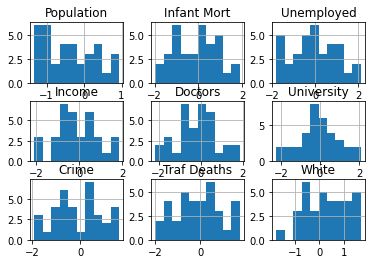

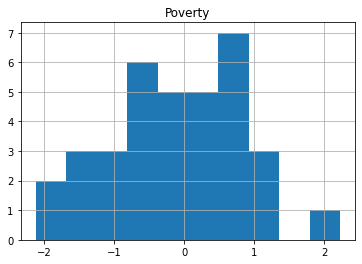

In [12]:
X_train_ss_yj.hist()
y_train_ss_yj.hist()